$ \theta = \{\psi, \sigma \} $

$\psi$: Parametros para definição do modelo que será utilizado em cada estado<br>
$\sigma$: Parametros para cada Modelo $\{\sigma_1, \sigma_2, ...\}$ <br>

$ \beta: S \mapsto [0,1]^k \;\; onde \;\; k = |\sigma|$ <br>
$ \beta(s; \psi)_i = p_{\psi}(\sigma_i | s) \; \forall \; i \in (1, 2, ..., k)$ <br>
A função $ \beta $ define a probabilidade de cada parametro em $ \sigma $ ser o modelo utilizado pra gerar a transição em um estado <br>

$\mu: S \times S \times A \times \sigma \mapsto [0,1] $ <br>
$\mu(s', s, a, \sigma_x)= p_{\sigma_x}(s'|s,a)$ <br>
A função $ \mu $ define a probabilidade de transição para um estado, dado um par de estado e ação, seguindo o modelo $\sigma_x$ <br>

In [1]:
import numpy as np
import random

force = .5
actions = np.array([(force,0), (-force,0), (0,force), (0,-force)])
theta = [5, (.005,.3)]

def mu(s, a, p=2):
    acts = actions[a]
    return s + acts + np.random.normal(0, p, 2)

def beta(x,y):
    psi, _ = theta
    # s = np.column_stack((x,y))
    # ref = np.zeros(shape=s.shape)
    # return 1*(np.linalg.norm(ref-s, axis=1) < psi)
    return 1*((x**2 + y**2)**(1/2) < psi)

def generate(s0, n):   
    _, sigma = theta
    s = s0
    for _ in range(n):
        a = np.random.choice(4, 1)[0]
        # yield s[0], a
        yield np.insert(s, s.size, a)
        m = beta(s[:,0], s[:,1])[0]
        s = mu(s, a, sigma[m])

def trajectory(s_0=(1,1), n=100):
    gen = generate(s_0, n)
    # return np.array([(s, a) for (s, a) in gen])
    return np.fromiter(gen, dtype=np.dtype((float, 3)))

s_0 = np.array([[0,0]])
n = 1000

O = trajectory(s_0, n)
# O[:,0:2]


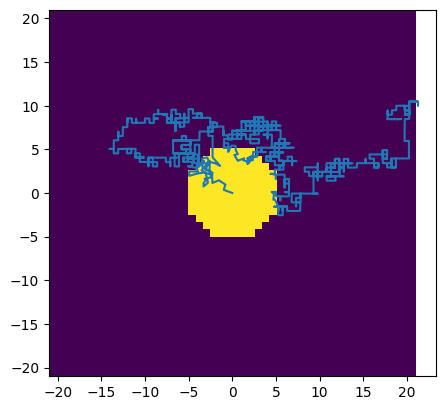

In [2]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(5, 5))
# ax.invert_yaxis()

size = 20
res = 50
x = np.linspace(-size, size, res).reshape(-1,1)
y = np.linspace(-size, size, res).reshape(-1,1)

X,Y = np.meshgrid(x,y)
ax.imshow(beta(X,Y), extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1))
ax.invert_yaxis()

x = np.array(O)[:,0]
y = np.array(O)[:,1]
ax.plot(np.array(O)[:,0], y)

$p_{\theta}(s_{t+1}|s_t, a_t) = \mu(s_{t+1}, s_t, a_t, \sigma_1) \; \times \; \beta(s_t)_1 + \mu(s_{t+1}, s_t, a_t, \sigma_2) \; \times \; \beta(s_t)_2 + ...$



$p_{\theta}(s_{t+1}|s_t, a_t) = \sum_{i=1}^k \mu(s_{t+1}, s_t, a_t, \sigma_i) \beta(s_t)_i \;\;\;\;\; for \;\; k = |\sigma_{\theta}|$  


$\mu: S \times S \times A \times \sigma_{\theta} \mapsto [0,1]; \;\; \mu(s', s, a, \sigma) = pdf(s'_x, (s_x+a_x), \sigma) \; \times \; pdf(s'_y, (s_y+a_y), \sigma)$

$ \beta: S \mapsto [0,1]; \;\; \beta(s; \psi_{\theta})_i = \frac{e^{\psi_{s,i}}}{\sum_{j=1}^k e^{\psi_{s,j}}} $;   <br>
$ for \;\; k = |\sigma_{\theta}| \;\; ; \;\; i=1,...,k $

$\cal{L}[\xi | \theta] = \sum_{t=0}^{\mathrm{T}-1} log \; p_{\theta}(s_{t+1}|s_t, a_t) - \epsilon$

$ \epsilon= k \times log \; n  $ 

$ \epsilon = \sum_{t=0}^{\mathrm{T}-1} \sum_{s' \; vizinho \; s_t} e^{}$

In [3]:
# import torch
# from torch.autograd import Variable
# from torch.distributions import normal
# import torch.nn as nn
# import torch.nn.functional as f

# class BetaModel(nn.Module):
#     def __init__(self, ):
#         super(BetaModel, self).__init__()
#         i = 8

#         self.layer_1 = nn.Linear(2,i).double()
#         self.layer_2 = nn.Linear(i,2).double()
        
#     def forward(self, x, y):
#         data = np.stack((x, y), axis=-1).reshape(x.size, 2)
#         data = torch.from_numpy(data).type(torch.DoubleTensor)
#         # data = torch.Tensor([x,y]).type(torch.DoubleTensor)
        
#         data = f.relu(self.layer_1(data))
#         data = f.softmax(self.layer_2(data), dim=1)
        
#         if len(x.shape) == 1:
#             return data
#         else:
#             return data.reshape(int(x.size**(1/2)), int(x.size**(1/2)), 2)

In [4]:
import torch
from torch.autograd import Variable
from torch.distributions import normal
import torch.nn as nn
import torch.nn.functional as f

class BetaModel(nn.Module):
    def __init__(self):
        super(BetaModel, self).__init__()
        n_features = 2
        n_models = 2
        n_hidden = 10

        self.model = nn.Sequential(
            nn.Linear(n_features, n_hidden).double(),
            nn.ReLU(),
            # nn.Linear(n_hidden, n_hidden).double(),
            # nn.ReLU(),
            nn.Linear(n_hidden, n_models).double(),
            nn.ReLU(),
            nn.Softmax(dim=1)
        )
        
    def forward(self, x):
        return self.model(x)

In [5]:
def loglike(beta, data):
    def prob(sig):
        acts = np.stack((
            np.take(actions[:,0], data[:-1,2].astype(int)), 
            np.take(actions[:,1], data[:-1,2].astype(int))
        ), axis=-1)

        s = Variable(torch.from_numpy(data[:-1,0:2])).type(torch.DoubleTensor)
        a = Variable(torch.from_numpy(acts)).type(torch.DoubleTensor)
        s_ = Variable(torch.from_numpy(data[1:,0:2])).type(torch.DoubleTensor)
        
        return torch.exp(normal.Normal(s[:,0] + a[:,0], sig).log_prob(s_[:,0])) * torch.exp(normal.Normal(s[:,1] + a[:,1], sig).log_prob(s_[:,1]))
    
    mi = torch.stack([prob(sig) for sig in theta[1]], dim=1)
    p_theta = torch.sum((mi * beta), 1) 

    # epsilon = len(theta[1]) * np.log(data.size)
    epsilon = 0
    return -torch.sum(torch.log(p_theta)) + epsilon


In [6]:

def train(model, data, loss, epochs=1000):
    x_train_tensor = torch.from_numpy(data[:-1,0:2]).type(torch.DoubleTensor)
    optim = torch.optim.SGD(model.parameters(), lr=1e-2)#, momentum=0.9)
    
    model.train(True)
    for epoch in range(epochs):
        outputs = model(x_train_tensor)
        ll = loss(outputs, data)
        if ll.data == torch.inf or torch.isnan(ll.data):
            break
        ll.backward()
        optim.step() 
        optim.zero_grad()
    model.train(False)

    return ll


In [7]:

beta_model = BetaModel()
train(beta_model, O, loglike)


tensor(-6947.7381, dtype=torch.float64, grad_fn=<AddBackward0>)

In [8]:
# print(ll)
# with torch.no_grad():
xT = torch.tensor([[100, 0]]).type(torch.DoubleTensor)
print(beta_model(xT))

tensor([[1., 0.]], dtype=torch.float64, grad_fn=<SoftmaxBackward0>)


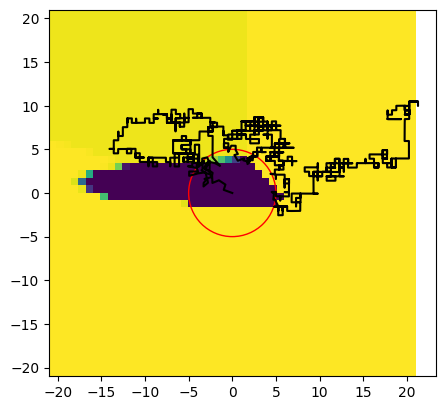

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

fig, ax = plt.subplots(figsize=(5, 5))
# ax.invert_yaxis()

# r = 10
# s = 20
# x = np.linspace(-r, r, s)#.reshape(-1,1)
# y = np.linspace(-r, r, s)#.reshape(-1,1)
x = np.linspace(-size, size, res).reshape(-1,1)
y = np.linspace(-size, size, res).reshape(-1,1)

X,Y = np.meshgrid(x,y)

with torch.no_grad():
    d = np.stack((X, Y), axis=-1).reshape(-1, 2)
    d = torch.from_numpy(d).type(torch.DoubleTensor)
    corr = beta_model(d)[:,0].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
    # ax.imshow(corr, extent=(-r, r, r, -r), vmin=0, vmax=1)
    ax.imshow(corr, extent=(int(min(x))-1, int(max(x))+1, int(max(y))+1, int(min(y))-1))
ax.invert_yaxis()
    # for i, lin in enumerate(X):
    #     for j, o in enumerate(Y):
    #         ax.text(j-r+(r/2/10), i-r+(r/2/10), (1,2)[o<.5], ha="right", va="bottom", color=("w", "black")[o>.5])
    #         ax.text(j-r+(r/2/10), i-r+(r/2/10), round(o, 2), ha="left", va="top", color=("w", "black")[o>.5], size=5.5)
        

x = np.array(O)[:,0]
y = np.array(O)[:,1]
ax.add_patch(Circle((0, 0), theta[0], edgecolor='red', fill=False))
ax.plot(x, y, color='black')

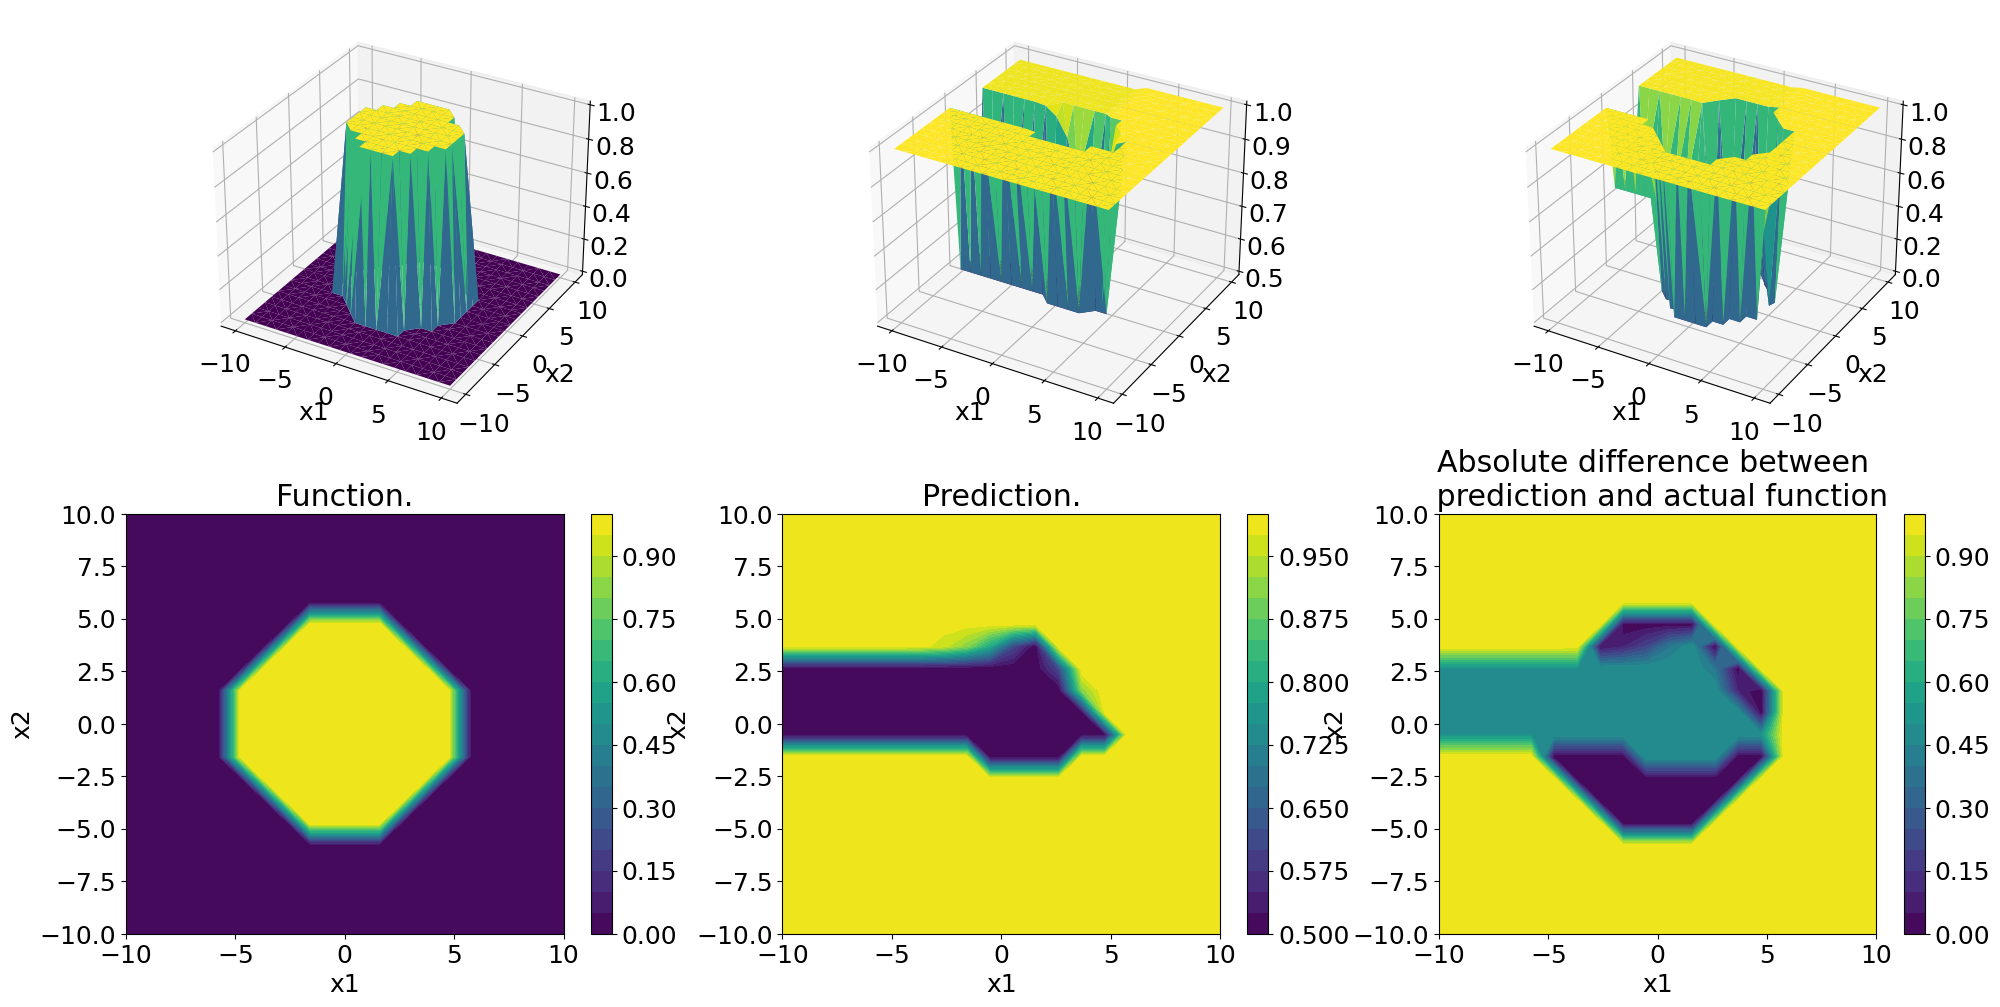

: 

In [10]:
# from mpl_toolkits.mplot3d import Axes3D

def plot(X1, X2, Y, res):    
    fig = plt.figure(1,figsize=(24,12))
    plt.rcParams.update({'font.size': 18})
    ax = fig.add_subplot(2, 3, 1, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), Y.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1')
    plt.ylabel('x2')
    ax = fig.add_subplot(2, 3, 4)
    im = ax.contourf(X1, X2, Y, levels=20)
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.colorbar(im)
    plt.title('Function.')
    ax = fig.add_subplot(2,3, 2, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), res.flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1')
    plt.ylabel('x2')
    ax = fig.add_subplot(2, 3, 5)
    im = ax.contourf(X1, X2, res, levels=20)
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.colorbar(im)
    plt.title('Prediction.')
    ax = fig.add_subplot(2,3, 3, projection='3d')
    im = ax.plot_trisurf(X1.flatten(), X2.flatten(), np.abs(res-Y).flatten(), cmap='viridis', linewidth=0.2, antialiased=True)
    plt.xlabel('x1')
    plt.ylabel('x2')
    ax = fig.add_subplot(2, 3, 6)
    im = ax.contourf(X1, X2, np.abs(res-Y), levels=20)
    plt.xlabel('x1')
    plt.ylabel('x2')
    fig.colorbar(im)
    plt.title('Absolute difference between \n prediction and actual function')
    #plt.savefig('2d_fun%d_units%d.pdf' % (fun_2d, units),bbox_inches='tight')

r = 10
x = np.linspace(-r, r, size).reshape(-1,1)
y = np.linspace(-r, r, size).reshape(-1,1)

X,Y = np.meshgrid(x,y)
d = np.stack((X, Y), axis=-1).reshape(-1, 2)
d = torch.from_numpy(d).type(torch.DoubleTensor)

with torch.no_grad():
    corr = beta_model(d)[:,0].reshape(int(X.size**(1/2)), int(X.size**(1/2)))
    plot(X,Y, beta(X,Y), corr)